### Whole-brain model 

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding")

In [2]:
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency import psd_array_multitaper
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from src.models import simulate, simulate_delayed

In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Load anatomical data

In [4]:
area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]

In [5]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 0

#### Simulation parameters

In [6]:
ntrials = 10
dt = 1e-4
fsamp = 1 / dt
time = np.arange(-4, 4, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 10
f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz
D = (D / dt).astype(int)
flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

seeds = np.random.randint(0, 10000, ntrials)

In [7]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.5
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling = (time > time_start) & (time < time_end)

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(0, 1e-1, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [8]:
coupling = CS[:, None] * coupling

In [9]:
Iext = np.zeros((ntrials, Nareas, len(time)))
Iext[:, 0] = coupling

In [10]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate(
            flnMat,
            30,
            40,
            -5,
            fsamp,
            1e-4,
            Npoints,
            Iext[trial],
            seeds[trial],
            decim=decim,
            stim_mode="amp",
        )
    ]

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


#### Convert to xarray

In [11]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), area_names, time[::decim]),
).sel(times=slice(-2, 4))

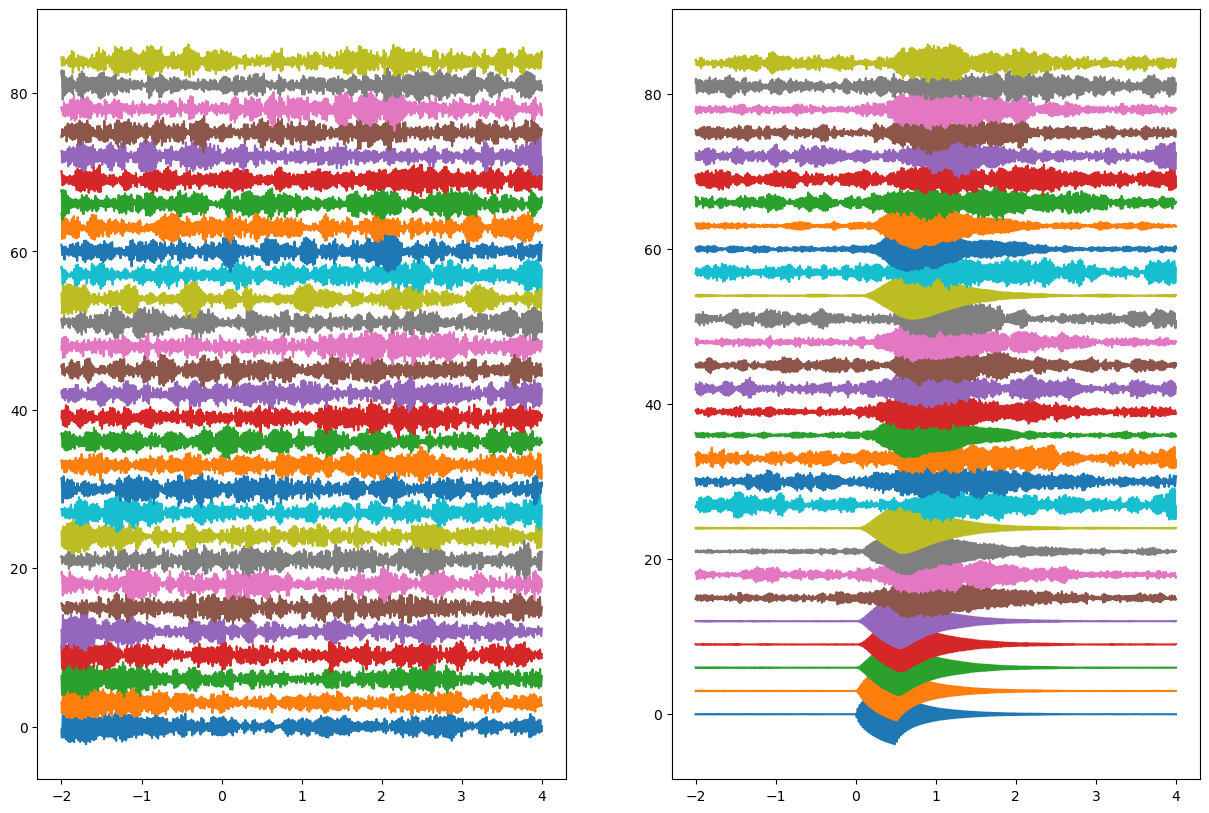

In [12]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [13]:
z = data.isel(roi=0) * np.conj(data.isel(roi=28))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

In [28]:
A.shape

(10, 6000)

In [14]:
labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

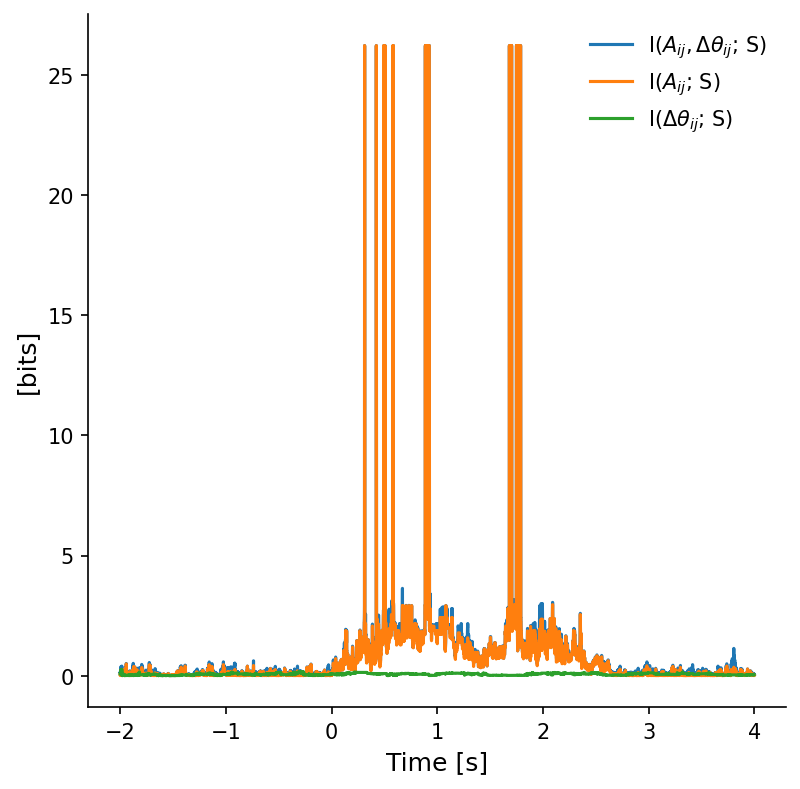

In [15]:
plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(111)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))


mv = np.stack((A, dphi), axis=0)


plt.plot(z_data[-1].times, mi_fcn_time(mv, labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(A[None], labels[None], False, True))
plt.plot(z_data[-1].times, mi_fcn_time(dphi[None], labels[None], False, True))

plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.savefig("figures/v1_24c_encoding.png", bbox_inches="tight")

In [25]:
mi_fcn?

Signature:     
mi_fcn(
    x: <function array at 0x7e73caa4dbc0>,
    y: <function array at 0x7e73caa4dbc0>,
    biascorrect: bool = False,
    copnorm: bool = False,
)
Call signature: mi_fcn(*args, **kwargs)
Type:           partial
String form:    functools.partial(<PjitFunction of <function mi_gc at 0x7e736907a480>>)
File:           ~/anaconda3/envs/test_env/lib/python3.11/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [26]:
from functools import partial


mi_fcn = get_mi("gc")

kw_mi = {"biascorrect": False, "copnorm": False}

mi_fcn_partial = partial(mi_fcn, **kw_mi)

In [27]:
mi_fcn_partial

functools.partial(<PjitFunction of <function mi_gc at 0x7e736907a480>>, biascorrect=False, copnorm=False)

In [16]:
flnMat_ = xr.DataArray(
    flnMat, dims=("targets", "sources"), coords=(area_names, area_names)
)

In [17]:
PPE = []
for n in tqdm(range(1, 29)):
    z = data.isel(roi=0) * np.conj(data.isel(roi=n))
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))

    labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

    mv = np.stack((A, dphi), axis=0)

    I12 = mi_fcn_time(mv, labels[None], False, True)
    I1 = mi_fcn_time(A[None], labels[None], False, True)
    I2 = mi_fcn_time(dphi[None], labels[None], False, True)

    PPE += [np.trapz(I2 - I1, dx=np.diff(data.times.values)[0])]

100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 15.61it/s]


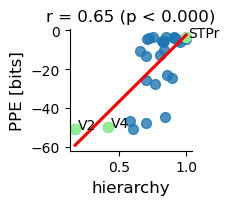

In [18]:
import seaborn as sns

plt.figure(figsize=(4 / 2.54, 4 / 2.54))
ax = plt.subplot(111)
sns.regplot(
    x=h[1:], y=PPE, ci=None, line_kws={"color": "r"}, scatter_kws={"s": 50}, n_boot=500
)

for i in range(1, 29):
    if data.roi.values[i] in ["V2", "V4", "STPr"]:
        plt.text(h[i] + 0.02, PPE[i - 1], data.roi.values[i])
        plt.scatter(h[i], PPE[i - 1], s=50, c="lightgreen")

r, p = scipy.stats.spearmanr(h[1:], PPE, alternative="greater")
plt.title(f"r = {r:.2f} (p < {p:.3f})")
plt.ylabel("PPE [bits]", fontsize=12)
plt.xlabel("hierarchy", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig("figures/ppe_hier.png", bbox_inches="tight")

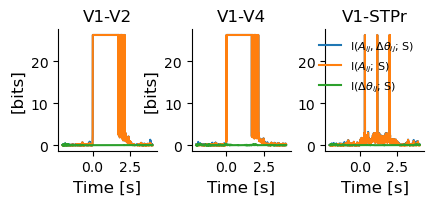

In [19]:
plt.figure(figsize=(12 / 2.54, 4 / 2.54))

ax = plt.subplot(131)

z = data.sel(roi="V1") * np.conj(data.sel(roi="V2"))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

mv = np.stack((A, dphi), axis=0)

I12 = mi_fcn_time(mv, labels[None], False, True)
I1 = mi_fcn_time(A[None], labels[None], False, True)
I2 = mi_fcn_time(dphi[None], labels[None], False, True)

plt.plot(data.times, I12)
plt.plot(data.times, I1)
plt.plot(data.times, I2)
plt.title("V1-V2", fontsize=12)
# ax.xaxis.set_ticklabels([])
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]


ax = plt.subplot(132)

z = data.sel(roi="V1") * np.conj(data.sel(roi="V4"))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

mv = np.stack((A, dphi), axis=0)

I12 = mi_fcn_time(mv, labels[None], False, True)
I1 = mi_fcn_time(A[None], labels[None], False, True)
I2 = mi_fcn_time(dphi[None], labels[None], False, True)

plt.plot(data.times, I12)
plt.plot(data.times, I1)
plt.plot(data.times, I2)
plt.title("V1-V4", fontsize=12)
# ax.xaxis.set_ticklabels([])
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

ax = plt.subplot(133)

z = data.sel(roi="V1") * np.conj(data.sel(roi="STPr"))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

mv = np.stack((A, dphi), axis=0)

I12 = mi_fcn_time(mv, labels[None], False, True)
I1 = mi_fcn_time(A[None], labels[None], False, True)
I2 = mi_fcn_time(dphi[None], labels[None], False, True)

plt.plot(data.times, I12)
plt.plot(data.times, I1)
plt.plot(data.times, I2)
plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
    fontsize=8,
)
plt.subplots_adjust(wspace=0.35)
plt.title("V1-STPr", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig("figures/ppe_hier_exemple.pdf", bbox_inches="tight")

In [20]:
data_no_noise = simulate(
    flnMat,
    30,
    40,
    -5,
    fsamp,
    0,
    Npoints,
    Iext[-1],
    seeds[-1],
    decim=decim,
    stim_mode="both",
)

data_no_noise = data_no_noise.real.T

In [21]:
data_no_noise = (
    data_no_noise - data_no_noise.mean(0, keepdims=True)
) / data_no_noise.std(0, keepdims=True)

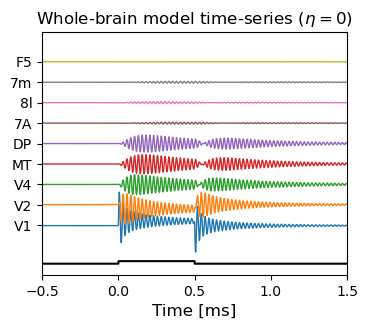

In [22]:
plt.figure(figsize=(10 / 2.54, 8 / 2.54))
sel_roi = ["V1", "V2", "V4", "MT", "DP", "7A", "8l", "7m", "F5"]
indexes = []

plt.plot(time, coupling[-1] * 10 - 15, c="k")

for pos in range(len(sel_roi)):
    indexes.append(np.where(np.array(area_names) == sel_roi[pos])[0][0])

for pos, i in enumerate(indexes):
    plt.plot(time[::decim], data_no_noise[:, i] + (pos * 8), lw=1)
plt.xlim(-.5, 1.5)
plt.yticks(np.arange(len(indexes)) * 8, np.array(area_names)[indexes]);
plt.xlabel("Time [ms]", fontsize=12)
plt.title(r"Whole-brain model time-series ($\eta=0$)")
plt.savefig("figures/wholebrain_no_noise_ts.png", bbox_inches="tight")

In [23]:
from hoi.metrics.base_hoi import HOIEstimator

In [24]:
data.coords

Coordinates:
  * trials   (trials) int64 80B 0 1 2 3 4 5 6 7 8 9
  * roi      (roi) <U5 580B 'V1' 'V2' 'V4' 'DP' 'MT' ... 'F7' '8B' 'STPr' '24c'
  * times    (times) float64 48kB -2.0 -1.999 -1.998 ... 3.997 3.998 3.999